In [ ]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error

def df_preview(df):
    for col in df.columns:
        print(col, "null count ::", df[col].isnull().sum(), "// mean ::", df[col].mean())

def df_col_distplot(df):
    for col in df.columns:
        print(col, "plot")
        sns.distplot(df.loc[df[col].notnull(), col])
        plt.title(col)
        plt.show()

def rmse_expm1(pred, true):
    return -np.sqrt(np.mean((np.expm1(pred)-np.expm1(true))**2))

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

In [ ]:
train = pd.read_csv('./drive/My Drive/ml_data/wine/train.csv', index_col='index')
test = pd.read_csv('./drive/My Drive/ml_data/wine/test.csv', index_col='index')
submission = pd.read_csv('./drive/My Drive/ml_data/wine/sample_submission.csv', index_col='index')

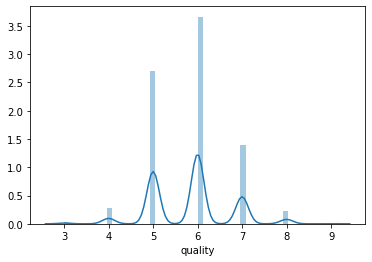

In [ ]:
sns.distplot(train['quality'])

In [ ]:
train[train['quality'] == 3].shape

(26, 13)

In [ ]:
train[train['quality'] == 9].shape

(5, 13)

In [ ]:
train.head()

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
index,,,,,,,,,,,,,
0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white
1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red
2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white
3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white
4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white


In [ ]:
test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
index,,,,,,,,,,,,
0,9.0,0.31,0.48,6.6,0.043,11.0,73.0,0.99380,2.90,0.38,11.6,white
1,13.3,0.43,0.58,1.9,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,red
2,6.5,0.28,0.27,5.2,0.040,44.0,179.0,0.99480,3.19,0.69,9.4,white
3,7.2,0.15,0.39,1.8,0.043,21.0,159.0,0.99480,3.52,0.47,10.0,white
4,6.8,0.26,0.26,2.0,0.019,23.5,72.0,0.99041,3.16,0.47,11.8,white


In [ ]:
submission

,quality
index,
0,0
1,0
2,0
3,0
4,0
...,...
995,0
996,0
997,0


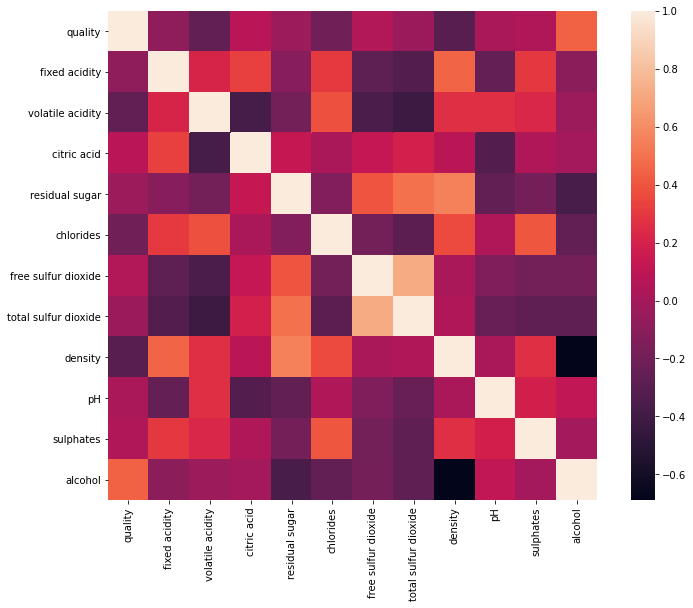

In [ ]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True)

In [ ]:
corrmat

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,1.000000,-0.076506,-0.261557,0.079157,-0.032848,-0.198148,0.055574,-0.039732,-0.299831,0.017931,0.042068,0.439615
fixed acidity,-0.076506,1.000000,0.210180,0.326992,-0.112544,0.303307,-0.277079,-0.323845,0.452161,-0.250462,0.300979,-0.096274
volatile acidity,-0.261557,0.210180,1.000000,-0.377986,-0.192677,0.385431,-0.352572,-0.418535,0.266759,0.264130,0.225174,-0.032897
citric acid,0.079157,0.326992,-0.377986,1.000000,0.135160,0.029121,0.129496,0.190955,0.088400,-0.322100,0.049013,-0.005376
residual sugar,-0.032848,-0.112544,-0.192677,0.135160,1.000000,-0.130339,0.396018,0.494788,0.557183,-0.259673,-0.182275,-0.361457
chlorides,-0.198148,0.303307,0.385431,0.029121,-0.130339,1.000000,-0.193143,-0.281654,0.364200,0.046937,0.400354,-0.259774
free sulfur dioxide,0.055574,-0.277079,-0.352572,0.129496,0.396018,-0.193143,1.000000,0.716829,0.027270,-0.145586,-0.189390,-0.182321
total sulfur dioxide,-0.039732,-0.323845,-0.418535,0.190955,0.494788,-0.281654,0.716829,1.000000,0.039707,-0.234412,-0.272236,-0.271566
density,-0.299831,0.452161,0.266759,0.088400,0.557183,0.364200,0.027270,0.039707,1.000000,0.020047,0.261879,-0.688053
pH,0.017931,-0.250462,0.264130,-0.322100,-0.259673,0.046937,-0.145586,-0.234412,0.020047,1.000000,0.187392,0.114959


In [ ]:
train.columns

Index(['quality', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'type'],
      dtype='object')

In [ ]:
target_cols = ['quality']
# param_cols = train.columns.drop(['quality', 'type'])
param_cols = train.columns.drop(['quality'])

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
index,,,,,,,,,,,,
0,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white
1,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red
2,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white
3,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white
4,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white
...,...,...,...,...,...,...,...,...,...,...,...,...
5492,7.7,0.150,0.29,1.3,0.029,10.0,64.0,0.99320,3.35,0.39,10.1,white
5493,6.3,0.180,0.36,1.2,0.034,26.0,111.0,0.99074,3.16,0.51,11.0,white
5494,7.8,0.150,0.34,1.1,0.035,31.0,93.0,0.99096,3.07,0.72,11.3,white


In [ ]:
x_data = pd.get_dummies(train[param_cols], columns=['type'])
y_data = train[target_cols]

In [ ]:
from lightgbm import LGBMClassifier

# 'type' 을 제외하고 테스트 했을 때
# Early stopping, best iteration is:
# [68]	valid_0's multi_logloss: 0.964236
# LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
#                importance_type='split', learning_rate=0.1, max_depth=-1,
#                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
#                n_estimators=2000, n_jobs=-1, num_iterations=1000, num_leaves=31,
#                objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
#                silent=True, subsample=1.0, subsample_for_bin=200000,
#                subsample_freq=0)

# one hot 인코딩 했을 때
# Early stopping, best iteration is:
# [67]	valid_0's multi_logloss: 0.961122
# LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
#                importance_type='split', learning_rate=0.1, max_depth=-1,
#                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
#                n_estimators=2000, n_jobs=-1, num_iterations=1000, num_leaves=31,
#                objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
#                silent=True, subsample=1.0, subsample_for_bin=200000,
#                subsample_freq=0)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.3, random_state=0)

lgbmc = LGBMClassifier(boosting_type='dart', metric='multiclass', learning_rate=0.1, n_estimators= 1000)
lgbmc.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=True)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[1]	valid_0's multi_logloss: 1.23282
[2]	valid_0's multi_logloss: 1.20414
[3]	valid_0's multi_logloss: 1.18297
[4]	valid_0's multi_logloss: 1.16405
[5]	valid_0's multi_logloss: 1.14613
[6]	valid_0's multi_logloss: 1.13118
[7]	valid_0's multi_logloss: 1.11746
[8]	valid_0's multi_logloss: 1.1241
[9]	valid_0's multi_logloss: 1.11097
[10]	valid_0's multi_logloss: 1.09961
[11]	valid_0's multi_logloss: 1.08964
[12]	valid_0's multi_logloss: 1.09351
[13]	valid_0's multi_logloss: 1.08447
[14]	valid_0's multi_logloss: 1.0757
[15]	valid_0's multi_logloss: 1.06748
[16]	valid_0's multi_logloss: 1.0588
[17]	valid_0's multi_logloss: 1.05186
[18]	valid_0's multi_logloss: 1.04557
[19]	valid_0's multi_logloss: 1.03986
[20]	valid_0's multi_logloss: 1.03441
[21]	valid_0's multi_logloss: 1.03609
[22]	valid_0's multi_logloss: 1.03165
[23]	valid_0's multi_logloss: 1.02617
[24]	valid_0's multi_logloss: 1.02184
[25]	valid_0's multi_logloss: 1.01785
[26]	valid_0's multi_logloss: 1.0148
[27]	valid_0's multi_logl

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='multiclass', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
test_data = pd.get_dummies(test, columns=['type'])
test_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
index,,,,,,,,,,,,,
0,9.0,0.31,0.48,6.60,0.043,11.0,73.0,0.99380,2.90,0.38,11.6,0,1
1,13.3,0.43,0.58,1.90,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,1,0
2,6.5,0.28,0.27,5.20,0.040,44.0,179.0,0.99480,3.19,0.69,9.4,0,1
3,7.2,0.15,0.39,1.80,0.043,21.0,159.0,0.99480,3.52,0.47,10.0,0,1
4,6.8,0.26,0.26,2.00,0.019,23.5,72.0,0.99041,3.16,0.47,11.8,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7.1,0.59,0.02,2.30,0.082,24.0,94.0,0.99744,3.55,0.53,9.7,1,0
996,8.7,0.15,0.30,1.60,0.046,29.0,130.0,0.99420,3.22,0.38,9.8,0,1
997,8.8,0.66,0.26,1.70,0.074,4.0,23.0,0.99710,3.15,0.74,9.2,1,0


In [ ]:
res = lgbmc.predict(test_data)
res

array([6, 6, 6, 5, 6, 6, 5, 6, 6, 7, 6, 5, 7, 6, 5, 5, 6, 7, 5, 5, 6, 6,
       5, 7, 6, 5, 5, 5, 5, 5, 7, 6, 5, 6, 5, 6, 5, 5, 6, 6, 6, 5, 6, 6,
       6, 6, 5, 7, 4, 6, 5, 5, 6, 4, 5, 6, 6, 5, 5, 6, 5, 6, 6, 6, 6, 6,
       5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 6, 7, 6, 7, 5, 6, 5, 4, 7, 5, 5, 5,
       7, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 5, 6, 6, 5, 6, 6, 6, 6, 7, 5,
       7, 7, 6, 5, 5, 6, 6, 7, 6, 5, 6, 5, 6, 7, 5, 5, 6, 6, 6, 7, 5, 5,
       4, 5, 6, 6, 6, 7, 5, 5, 5, 6, 5, 5, 5, 5, 7, 6, 7, 6, 5, 8, 6, 5,
       6, 5, 5, 5, 6, 5, 5, 6, 6, 7, 6, 5, 5, 6, 5, 6, 5, 5, 6, 5, 5, 6,
       6, 5, 6, 6, 6, 5, 7, 7, 5, 6, 6, 6, 5, 6, 6, 5, 5, 5, 5, 6, 7, 5,
       5, 5, 6, 6, 6, 5, 5, 5, 6, 6, 6, 6, 7, 5, 5, 6, 6, 6, 5, 6, 6, 7,
       5, 5, 6, 6, 7, 6, 6, 5, 6, 5, 6, 7, 7, 6, 6, 6, 6, 6, 6, 7, 6, 6,
       6, 6, 7, 6, 5, 6, 6, 7, 5, 6, 7, 7, 6, 6, 6, 7, 6, 6, 7, 5, 5, 7,
       5, 5, 6, 5, 6, 6, 6, 5, 5, 5, 6, 5, 7, 7, 5, 6, 6, 6, 6, 6, 7, 7,
       6, 6, 6, 6, 5, 5, 5, 6, 5, 7, 8, 6, 5, 7, 7,

In [ ]:
submission = pd.read_csv('./drive/My Drive/ml_data/wine/sample_submission.csv', index_col='index')
submission['quality'] = res

import time
from google.colab import files
filename = time.strftime('%Y-%m-%d-%H_%M_%S')+'submission.csv'
submission.to_csv(filename, index=True)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.3, random_state=0)
# test_data = pd.get_dummies(test, columns=['type'])
dummy = pd.get_dummies(y_data, columns=['quality'])
dummy

x_train, x_val, y_train, y_val = train_test_split(x_data, dummy, test_size=0.1, random_state=123)

In [ ]:
# iris를 keras로 분석한 예제
# https://pinkwink.kr/1128
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((4947, 13), (550, 13), (4947, 7), (550, 7))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

In [ ]:
model = Sequential()

model.add(Dense(64, input_shape=(13,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 7)                 455       
Total params: 5,511
Trainable params: 5,511
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(x_data, dummy, validation_data=(x_val, y_val), epochs=100)

Train on 5497 samples, validate on 550 samples
Epoch 1/100
5497/5497 [==============================] - 1s 133us/step - loss: 1.0261 - accuracy: 0.5467 - val_loss: 1.0284 - val_accuracy: 0.5400
Epoch 2/100
5497/5497 [==============================] - 1s 128us/step - loss: 1.0139 - accuracy: 0.5518 - val_loss: 1.0638 - val_accuracy: 0.5182
Epoch 3/100
5497/5497 [==============================] - 1s 130us/step - loss: 1.0164 - accuracy: 0.5543 - val_loss: 1.0612 - val_accuracy: 0.5182
Epoch 4/100
5497/5497 [==============================] - 1s 127us/step - loss: 1.0252 - accuracy: 0.5479 - val_loss: 1.0230 - val_accuracy: 0.5291
Epoch 5/100
5497/5497 [==============================] - 1s 128us/step - loss: 1.0155 - accuracy: 0.5559 - val_loss: 1.0305 - val_accuracy: 0.5036
Epoch 6/100
5497/5497 [==============================] - 1s 130us/step - loss: 1.0104 - accuracy: 0.5594 - val_loss: 1.0471 - val_accuracy: 0.5273
Epoch 7/100
5497/5497 [==============================] - 1s 126us/step 

In [ ]:
hist.history

{'accuracy': [0.5466618,
  0.5517555,
  0.55430233,
  0.54793525,
  0.5559396,
  0.559396,
  0.55957794,
  0.5548481,
  0.5588503,
  0.5608514,
  0.55430233,
  0.55630344,
  0.55848646,
  0.5541204,
  0.55648535,
  0.55848646,
  0.557213,
  0.5664908,
  0.55775875,
  0.55430233,
  0.56503546,
  0.55630344,
  0.55339277,
  0.56358016,
  0.5592141,
  0.55975986,
  0.5523012,
  0.55521196,
  0.5643078,
  0.56176096,
  0.5586684,
  0.559396,
  0.5606695,
  0.55975986,
  0.5612152,
  0.55994177,
  0.5653993,
  0.5652174,
  0.5664908,
  0.5610333,
  0.5626705,
  0.55757684,
  0.56667274,
  0.570493,
  0.5663089,
  0.5643078,
  0.5674004,
  0.566127,
  0.57012916,
  0.5612152,
  0.566127,
  0.56667274,
  0.5675823,
  0.5664908,
  0.5697653,
  0.5695834,
  0.56885576,
  0.56358016,
  0.56485355,
  0.5708568,
  0.5715845,
  0.5690377,
  0.56685466,
  0.5710387,
  0.56994724,
  0.5746771,
  0.56685466,
  0.56994724,
  0.563944,
  0.5664908,
  0.5663089,
  0.5715845,
  0.57031107,
  0.5724941,
  

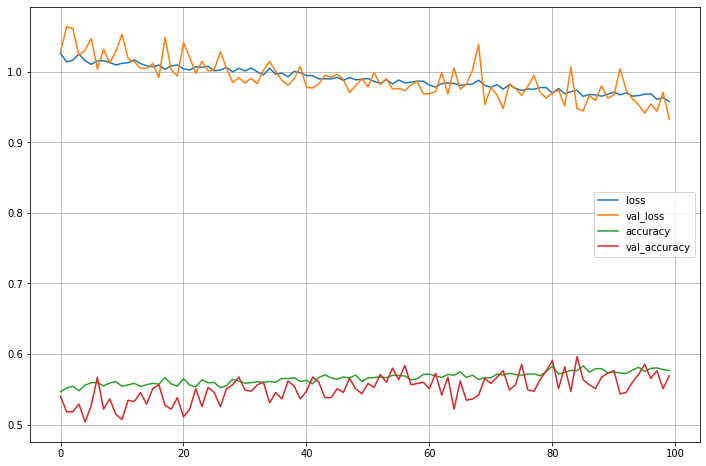

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss', 'accuracy','val_accuracy'])
plt.grid()
plt.show()

In [ ]:
model2 = Sequential()

model2.add(Dense(130, input_shape=(13,), activation='relu'))
model2.add(Dense(70, activation='relu'))
model2.add(Dense(7, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 130)               1820      
_________________________________________________________________
dense_23 (Dense)             (None, 70)                9170      
_________________________________________________________________
dense_24 (Dense)             (None, 7)                 497       
Total params: 11,487
Trainable params: 11,487
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist2 = model2.fit(x_data, dummy, validation_data=(x_val, y_val), epochs=100)

Train on 5497 samples, validate on 550 samples
Epoch 1/100
5497/5497 [==============================] - 1s 134us/step - loss: 0.9958 - accuracy: 0.5589 - val_loss: 0.9637 - val_accuracy: 0.5545
Epoch 2/100
5497/5497 [==============================] - 1s 133us/step - loss: 0.9844 - accuracy: 0.5701 - val_loss: 0.9663 - val_accuracy: 0.5418
Epoch 3/100
5497/5497 [==============================] - 1s 131us/step - loss: 0.9796 - accuracy: 0.5734 - val_loss: 0.9615 - val_accuracy: 0.5855
Epoch 4/100
5497/5497 [==============================] - 1s 132us/step - loss: 0.9775 - accuracy: 0.5760 - val_loss: 0.9494 - val_accuracy: 0.5745
Epoch 5/100
5497/5497 [==============================] - 1s 130us/step - loss: 0.9783 - accuracy: 0.5725 - val_loss: 0.9630 - val_accuracy: 0.5364
Epoch 6/100
5497/5497 [==============================] - 1s 133us/step - loss: 0.9943 - accuracy: 0.5614 - val_loss: 0.9444 - val_accuracy: 0.6000
Epoch 7/100
5497/5497 [==============================] - 1s 129us/step 

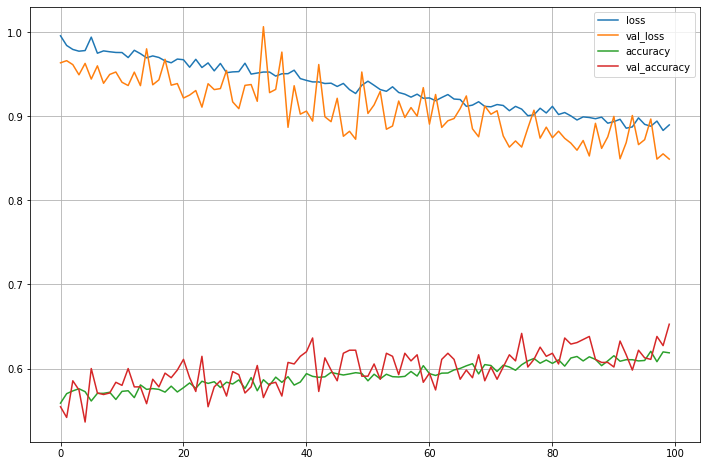

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.legend(['loss','val_loss', 'accuracy','val_accuracy'])
plt.grid()
plt.show()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_107 (Dense)            (None, 130)               1820      
_________________________________________________________________
dense_108 (Dense)            (None, 70)                9170      
_________________________________________________________________
dense_109 (Dense)            (None, 7)                 497       
Total params: 11,487
Trainable params: 11,487
Non-trainable params: 0
_________________________________________________________________
Train on 5497 samples, validate on 550 samples
Epoch 1/100
5497/5497 [==============================] - 1s 151us/step - loss: 1.6860 - accuracy: 0.3973 - val_loss: 1.5862 - val_accuracy: 0.4218
Epoch 2/100
5497/5497 [==============================] - 1s 127us/step - loss: 1.3068 - accuracy: 0.4264 - val_loss: 1.3867 - val_accuracy: 0.4218
Epoch 3/100
5497/5497 [===============

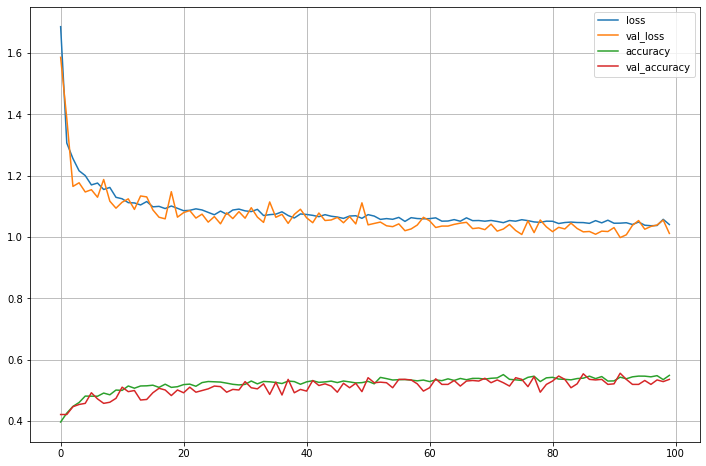

In [ ]:
from keras.optimizers import SGD, Adam

model3 = Sequential()

model3.add(Dense(130, input_shape=(13,), activation='relu'))
# model3.add(Dropout(0.2))
model3.add(Dense(70, activation='relu'))
# model3.add(Dense(14, activation='relu'))
# model3.add(Dropout(0.2))
# model3.add(Dense(13, activation='relu'))
# model3.add(Dropout(0.2))
model3.add(Dense(7, activation='softmax'))

model3.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(lr=0.005), 
    # optimizer=SGD(lr=0.01,momentum=0.9, nesterov=True), 
    metrics=['accuracy'])

model3.summary()

hist3 = model3.fit(x_data, dummy, validation_data=(x_val, y_val), epochs=300)

plt.figure(figsize=(12,8))
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.legend(['loss','val_loss', 'accuracy','val_accuracy'])
plt.grid()
plt.show()